# Description

This notebook develops a daily flight count model for the Hartsfield Jackson International Airport (ATL) in Atlanta, GA.  It is focused on building a model for non-pandemic flight patterns.  Then this model is scored on the pandemic time period in order to determine the flights expected had the airport been operating without the burden of the pandemic.

Special credit should be given to the Forecasting Energy Demand developers that developed the Azure Machine Learning documentation examples: 
https://github.com/Azure/MachineLearningNotebooks

https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/



# Set up workspace

In [25]:
print("Hello World")

Hello World


### Import packages etc

In [26]:
import pandas as pd
import numpy as np
import re
import datetime
from azureml.core import Workspace, Dataset, workspace

subscription_id = 'f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17'
resource_group = 'hackathon'
workspace_name = 'Iteration1_ML'

workspace = Workspace(subscription_id, resource_group, workspace_name)

### Set up experiment

In [27]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

### Set up workspace

In [28]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'non_COVID_model_JP'

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17
Workspace,iteration1_ml
Resource Group,hackathon
Location,eastus2
Run History Name,non_COVID_model_JP


### Create AmlCompute

In [29]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "flights-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Start Data Prep for Modeling

### Set up designated variables

In [30]:
target_column_name = 'counts_x'
time_column_name = 'Date'

### Read in data as dataset tabular object

In [31]:
dataset = Dataset.get_by_name(workspace, name='ATL_training_autoML').with_timestamp_columns(fine_grain_timestamp=time_column_name) 
#preview first 5 rows
dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,19556,ATL,2019-01-01,GA,952,Tuesday,1,1,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,19562,ATL,2019-01-02,GA,1241,Wednesday,2,2,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,19568,ATL,2019-01-03,GA,1162,Thursday,3,3,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,19574,ATL,2019-01-04,GA,1164,Friday,4,4,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,19580,ATL,2019-01-05,GA,865,Saturday,5,5,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Split the data into train and test sets

In [67]:
# split into train based on time, non covid times
train0 = dataset.time_before(datetime(2020, 2, 1, 0), include_boundary=False)
train0.to_pandas_dataframe().reset_index(drop=True).sort_values(time_column_name).tail(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
391,19715,ATL,2020-01-27,GA,1299,Monday,0,27,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
392,19721,ATL,2020-01-28,GA,1260,Tuesday,1,28,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
393,19727,ATL,2020-01-29,GA,1265,Wednesday,2,29,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
394,19733,ATL,2020-01-30,GA,1290,Thursday,3,30,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
395,19739,ATL,2020-01-31,GA,1283,Friday,4,31,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [68]:
# split into test and forecasting period
test0 = dataset.time_between(datetime(2020, 2, 1, 0), datetime(2020, 12, 31, 0))
test0.to_pandas_dataframe().reset_index(drop=True).head(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,19745,ATL,2020-02-01,GA,857,Saturday,5,1,February,2,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,19751,ATL,2020-02-02,GA,984,Sunday,6,2,February,2,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,19757,ATL,2020-02-03,GA,1294,Monday,0,3,February,2,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,19763,ATL,2020-02-04,GA,1257,Tuesday,1,4,February,2,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,19769,ATL,2020-02-05,GA,1261,Wednesday,2,5,February,2,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### There are too many input columns.  Do first round of feature selection

In [69]:
varsToKeep=[
'Date',
'counts_x',
'DOW_x',
'day_x',
'month_x',
'mint',
'maxt',
'temp',
'dew',
'humidity',
'wspd',
'precip',
'precipcover',
'snowdepth',
'visibility',
'cloudcover',
'sealevelpressure',
'weathertype',
'conditions']

# =============================================================================
# removed these for being covid related (in non-covid model)
#'positiveIncrease',
#'deathIncrease',
#'hospitalizedIncrease'

# removed these for being cumulative
#'positive',
#'probableCases',
#'death',

# removed these for being all 0
#'hospitalizedCurrently',
#'inIcuCurrently',
#'onVentilatorCurrently',


#removed these for being missing
#'wgust',
#'windchill',
#'heatindex',
# =============================================================================

In [70]:
train=train0.keep_columns(varsToKeep)
test=test0.keep_columns(varsToKeep)

In [36]:
#print for viewing
train.to_pandas_dataframe().reset_index(drop=True).tail(5)

,Date,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,dew,humidity,wspd,precip,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions
391,2020-01-27,1299,Monday,27,January,43.00,52.10,47.70,39.60,73.62,14.90,0.00,4.17,0.00,9.90,67.40,1014.60,Light Rain,Partially cloudy
392,2020-01-28,1260,Tuesday,28,January,37.10,57.80,47.10,33.40,62.90,13.80,0.00,0.00,0.00,9.90,20.20,1016.50,"Mist, Rain, Light Rain",Clear
393,2020-01-29,1265,Wednesday,29,January,42.10,52.10,47.20,33.10,58.06,11.40,0.00,0.00,0.00,9.90,75.90,1016.50,None,Overcast
394,2020-01-30,1290,Thursday,30,January,39.80,59.00,48.20,36.20,63.90,10.30,0.00,0.00,0.00,9.90,28.30,1019.60,Mist,Partially cloudy
395,2020-01-31,1283,Friday,31,January,39.80,44.90,41.90,36.80,82.13,14.90,0.08,16.67,0.00,6.90,87.10,1021.10,"Mist, Light Drizzle, Rain, Heavy Rain, Light Rain","Rain, Overcast"


In [37]:
#print for viewing
test.to_pandas_dataframe().reset_index(drop=True).head(5)

,Date,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,dew,humidity,wspd,precip,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions
0,2020-02-01,857,Saturday,1,February,39.80,50.00,44.40,37.90,78.30,13.80,0.00,4.17,0.00,7.80,81.40,1017.00,"Mist, Rain, Heavy Rain, Light Rain",Overcast
1,2020-02-02,984,Sunday,2,February,35.90,65.90,50.20,32.20,54.22,13.90,0.00,0.00,0.00,9.90,23.40,1017.10,None,Clear
2,2020-02-03,1294,Monday,3,February,43.00,75.80,59.30,36.20,45.59,16.10,0.00,0.00,0.00,9.90,46.50,1017.80,None,Partially cloudy
3,2020-02-04,1257,Tuesday,4,February,56.90,68.00,61.80,51.40,69.35,12.70,0.00,0.00,0.00,9.90,72.60,1016.70,Light Rain,Partially cloudy
4,2020-02-05,1261,Wednesday,5,February,61.10,66.80,63.70,59.20,85.41,17.20,0.36,45.83,0.00,7.70,88.20,1011.40,"Mist, Thunderstorm, Rain, Heavy Rain, Light Rain","Rain, Overcast"


# Modeling

### Set forecast horizon

In [38]:
forecast_horizon = 30

## Train the model

In [39]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    freq='D'
)

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blocked_models = ['ExtremeRandomTrees', 'Prophet','VotingEnsemble'],                             
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                             forecasting_parameters=forecasting_parameters,
                             enable_voting_ensemble=False)

In [40]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run.wait_for_completion()

Running on remote.
No run_configuration provided, running on flights-cluster with default configuration
Running on remote compute: flights-cluster
Parent Run ID: AutoML_366d7f0c-4d2b-494a-b23a-5d8627527a9f

Current status: DatasetFeaturizationCompleted. Beginning to featurize the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

****************************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

**********************************************************************

{'runId': 'AutoML_366d7f0c-4d2b-494a-b23a-5d8627527a9f',
 'target': 'flights-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-04-05T11:48:53.663252Z',
 'endTimeUtc': '2021-04-05T12:12:56.867758Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'flights-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"non_COVID_model_JP","subscription_id":"f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17","resource_group":"hackathon","workspace_name":"iteration1_ml","region":"eastus2","compute_target":"flights-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_v

# Results

### Retrieve the Best Model

In [41]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps
#fitted_model

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None,
                        lookback_features_removed=False,
                        pipeline=<azureml.automl.runtime.featurizer.transformer.timeseries.forecasting_pipeline.AzureMLForecastPipeline object at 0x7fee715eab70>,
                        pipeline_type=<TimeSeriesPipelineType.FULL: 1>,
                        time_index_non_holiday_features=['_automl_year',
                                                         '_automl_year_iso',
                                                         '_automl_half',
                                                         '_automl_quarter',
                                                         '_automl_month',
                                                         '_automl_day',
                                                         '_automl_wday',
                                                         '_automl_qday',
                                       

### View featurization

In [42]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['DOW_x',
 'day_x',
 'month_x',
 'mint',
 'maxt',
 'temp',
 'dew',
 'humidity',
 'wspd',
 'precip',
 'precipcover',
 'snowdepth',
 'visibility',
 'cloudcover',
 'sealevelpressure',
 'weathertype',
 'conditions',
 '_automl_target_col_WASNULL',
 'day_x_WASNULL',
 'mint_WASNULL',
 'maxt_WASNULL',
 'temp_WASNULL',
 'dew_WASNULL',
 'humidity_WASNULL',
 'wspd_WASNULL',
 'precip_WASNULL',
 'precipcover_WASNULL',
 'snowdepth_WASNULL',
 'visibility_WASNULL',
 'cloudcover_WASNULL',
 'sealevelpressure_WASNULL',
 '_automl_year',
 '_automl_year_iso',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_wday',
 '_automl_qday',
 '_automl_week']

In [43]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,DOW_x,Categorical,No,1,[LabelEncoder]
1,day_x,Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,month_x,Categorical,No,1,[LabelEncoder]
3,mint,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,maxt,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,dew,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,humidity,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,wspd,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,precip,Numeric,No,2,"[MedianImputer, ImputationMarker]"


### Forecast against the test sample and the pandemic time period

In [71]:
X_test = test.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

#also partition out a covid period prediction for forecasting
covid0= dataset.time_between(datetime(2020, 3, 1, 0), datetime(2020, 12, 31, 0))
covid=train0.keep_columns(varsToKeep)
X_covid =  covid.to_pandas_dataframe().reset_index(drop=True)
y_covid = X_covid.pop(target_column_name).values

#X_test
#y_test

X_covid
#y_covid

,Date,DOW_x,day_x,month_x,mint,maxt,temp,dew,humidity,wspd,precip,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions
0,2019-01-01,Tuesday,1,January,57.80,65.90,62.80,58.30,85.35,6.90,0.14,29.17,0.00,8.30,71.70,1019.10,"Mist, Rain, Fog, Heavy Rain, Light Rain","Rain, Partially cloudy"
1,2019-01-02,Wednesday,2,January,48.80,59.00,53.70,49.40,85.47,9.10,0.45,41.67,0.00,7.30,77.00,1020.90,"Mist, Rain, Fog, Heavy Rain, Light Rain","Rain, Overcast"
2,2019-01-03,Thursday,3,January,50.00,55.10,53.10,50.60,91.37,13.80,0.23,50.00,0.00,2.80,88.50,1016.70,"Mist, Light Drizzle, Rain, Heavy Rain, Light Rain","Rain, Overcast"
3,2019-01-04,Friday,4,January,45.00,65.90,55.10,49.20,81.49,25.20,1.45,50.00,0.00,5.30,79.60,1008.90,"Mist, Light Drizzle, Rain, Fog, Heavy Rain, Light Rain","Rain, Overcast"
4,2019-01-05,Saturday,5,January,44.00,59.00,49.40,36.30,61.79,20.70,0.00,0.00,0.00,9.90,36.40,1015.80,None,Partially cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2020-01-27,Monday,27,January,43.00,52.10,47.70,39.60,73.62,14.90,0.00,4.17,0.00,9.90,67.40,1014.60,Light Rain,Partially cloudy
392,2020-01-28,Tuesday,28,January,37.10,57.80,47.10,33.40,62.90,13.80,0.00,0.00,0.00,9.90,20.20,1016.50,"Mist, Rain, Light Rain",Clear
393,2020-01-29,Wednesday,29,January,42.10,52.10,47.20,33.10,58.06,11.40,0.00,0.00,0.00,9.90,75.90,1016.50,None,Overcast
394,2020-01-30,Thursday,30,January,39.80,59.00,48.20,36.20,63.90,10.30,0.00,0.00,0.00,9.90,28.30,1019.60,Mist,Partially cloudy


In [72]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

#y_predictions_covid,X_trans_covid = fitted_model.forecast(X_covid)

###### method from:
https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.ipynb

In [73]:
# from:
# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.ipynb

import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)

#### Align Datasets

In [74]:
df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
#df_all_covid = align_outputs(y_predictions_covid, X_trans_covid, X_covid, y_covid, target_column_name)

### Determine Test Period fit statistics

[Test data scores]

normalized_median_absolute_error:   0.038
normalized_root_mean_squared_error:   0.105
spearman_correlation:   0.754
r2_score:   0.908
mean_absolute_error:   32.708
median_absolute_error:   17.500
normalized_root_mean_squared_log_error:   0.103
root_mean_squared_error:   48.365
root_mean_squared_log_error:   0.045
mean_absolute_percentage_error:   2.926
normalized_mean_absolute_error:   0.071
explained_variance:   0.915


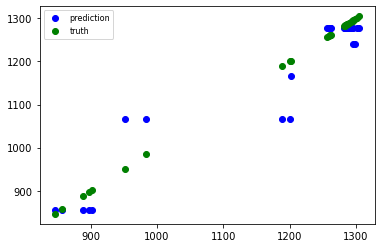

In [81]:

from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

df_test=df_all[(df_all.Date<=pd.Timestamp(2020,3,1))]

# use automl metrics module
scores = scoring.score_regression(
    y_test=df_test[target_column_name],
    y_pred=df_test['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs for testing period
%matplotlib inline
test_pred = plt.scatter(df_test[target_column_name], df_test['predicted'], color='b')
test_test = plt.scatter(df_test[target_column_name], df_test[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()


### Plot the results, Test Partition and Pandemic Time Period

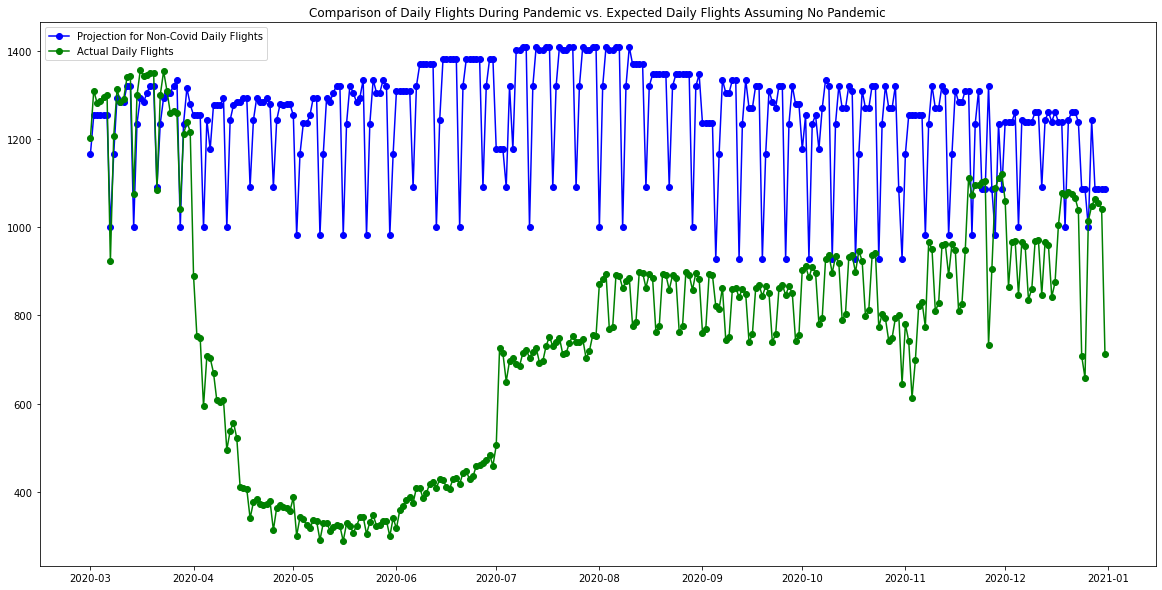

In [82]:
import datetime
%matplotlib inline
plt.figure(figsize=(20,10)) 
new_df_all=df_all[(df_all.Date>=datetime.datetime(2020, 3, 1, 0, 0, 0))]

plt.title("Comparison of Daily Flights During Pandemic vs. Expected Daily Flights Assuming No Pandemic")
test_pred = plt.plot(new_df_all['Date'], new_df_all['predicted'], color='b', label="Projection for Non-Covid Daily Flights", marker="o")
test_test = plt.plot(new_df_all['Date'], new_df_all[target_column_name], color='g', label="Actual Daily Flights", marker="o")
plt.legend(loc='upper left')
plt.show()

### Determine number of flights grounded

In [78]:
total_nonpandemic_flights=new_df_all['predicted'].sum()
total_pandemic_flights=new_df_all[target_column_name].sum()
diff=total_nonpandemic_flights-total_pandemic_flights

print('Expected (non-pandemic) flights:     '+'{:,}'.format(int(total_nonpandemic_flights)))

print('Actual pandemic flights:             '+'{:,}'.format(int(total_pandemic_flights)))

print('Flights grounded due to pandemic:    '+'{:,}'.format(int(diff)))

total_percent_reduction = diff/total_nonpandemic_flights*100

print('Percent reduction in flights:            '+'{:,}'.format(int(total_percent_reduction))+"%")

Expected (non-pandemic) flights:     382,281
Actual pandemic flights:             233,549
Flights grounded due to pandemic:    148,732
Percent reduction in flights:            38%


### Confirm the run is completed

In [79]:
automl_run, fitted_model = remote_run.get_output()